# Цели и задачи проекта

В качестве дипломного проекта было выбрано соревнование на kaggle (https://www.kaggle.com/c/severstal-steel-defect-detection) от компании Северсталь, посвященное семантической сегментации. А именно, определению и классификации дефектов стали на прокатном стане. Возможно четыре различных дефекта - в основном - это изломы, царапины, коррозия или эмульсия. В тренировочном файле у нас есть название картинки, номер дефекта и координаты пикселей с дефектами. 

Вводное видео как все происходит c комментариями - https://youtu.be/8Fg-1En1jlY?t=219
Видео проката - https://www.youtube.com/watch?v=qSTTVnzfKsI

Цели проекта
* улучшить метрику бейзлайна? запустить обучение от начала до конца?

Что интересно попробовать
* соревнование уже достаточно старое - возможно будет интересно попробовать применить какое-то state-of-the-art решение из текущих - и посмотреть, станет ли лучше.
* сделать валидацию
* изучить сервис для проведения экспериментов (neptune.ai, MLflow, MLcomp, tensorboard, wandb.ai)

Задачи
* подготовить eda
* подготовить валидацию
* попробовать улучшить текущей модели - протестировать другую базовую модель, оптимайзер, число замороженных слоев, количество эпох, применить другие метрики - то, что мы пробовали на других проектах
* применить sota 

Метрика

Это соревнование оценивается по среднему коэффициенту Дайса. Коэффициент Дайса можно использовать для сравнения пиксельного соответствия между прогнозируемой сегментацией и истинной.

Какие еще метрики интересно?
- матрица ошибок
- IoU 
Цель - учитывать уровень недобраковки или перебраковки

## импортируем модули

In [38]:
# pip install colorlover
# pip install plotly

# общий импорт
import numpy as np  # linear algebra
import pandas as pd

pd.set_option("display.max_rows", 101)
import os

print(
    os.listdir(
        "/Users/alina/Documents/диплом/severstal-steel-defect-detection"))
import cv2
# import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
# from collections import Counter
# from PIL import Image
import math
import seaborn as sns
# from collections import defaultdict
from pathlib import Path
# import cv2
# from tqdm import tqdm
import plotly.graph_objs as go

['test_images', '.DS_Store', 'train.csv', 'train_images', 'sample_submission.csv']


In [2]:
# адрес папки с данными
input_dir = "/Users/alina/Documents/диплом/severstal-steel-defect-detection"

Take-Away in EDA
- в текущей выборке примерно одинкаковое количество фото с дефектами (6666) и без (5902)
- выборка несбалансированна - 73% изображений - это примеры дефектов 3 класса 
- Data augmentation and resampling techniques will be required to perform the defect detection
- большинство изображений имеет только один вид дефекта
- все изображения одинакового размера - 1600, 256
- Pandas profiling не дал новых инсайтов. Корреляция не обнаружена???? А она могла быть? 

## Загружаем данные
### Описание файлов
* train_images/ - папка с тренировочными изображениями
* test_images/ - папка с тестовыми изображениями
* train.csv - файл с описанием всех дефектов
* sample_submission.csv - файл для формирования предсказания для загрузки на kaggle

In [3]:
# загружаем данные
train_df = pd.read_csv(input_dir + "/train.csv")
sample_sub_df = pd.read_csv(input_dir + "/sample_submission.csv")

In [4]:
# проверяем формат
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


Всего три столбца: ImageId - название картинки, ClassId - класс дефекта и EncodedPixels - разметка дефектов - содердит в себе пару из стартового пикселя и размера дефекта. Например, '1 3' означает, что стартовый пиксель 1 и всего 3 пикселя (1, 2, 3)

In [14]:
sample_sub_df.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


В файле sample_submission.csv хранится название картинки, разметка дефектов??? и столбец для предсказания дефекта

### Проверяем количество примеров для каждого класса

In [15]:
train_df.info()
# всего у нас 7095 объектов, ImageId и EncodedPixels - это объекты и ClassId - число

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [10]:
train_df['ClassId'].value_counts(dropna=False)
# выборка несбалансирована, больше всего дефектов 3 класса

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [6]:
# проверим сколько изображений используется несколько раз
train_df['ImageId'].value_counts(dropna=False)
# при этом два изображения имеют три дефекта, посмотрим сколько изображений имеют два дефекта
# таких изображений 425

ef24da2ba.jpg    3
db4867ee8.jpg    3
cb933c3e8.jpg    2
6ee81c40c.jpg    2
8527d0b55.jpg    2
                ..
74abdf1ef.jpg    1
72bb7c7bc.jpg    1
4c03cad47.jpg    1
b8be43898.jpg    1
6c1bc5d11.jpg    1
Name: ImageId, Length: 6666, dtype: int64

In [7]:
# оставим только изображения с дефектами
squashed = train_df.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# сгруппируем по названию изображения
squashed = (train_df[['ImageId', 'EncodedPixels',
                      'ClassId']].groupby('ImageId', as_index=False).agg(list))

# сосчитаем количество меток на одно изображение
squashed['DistinctDefectTypes'] = squashed['ClassId'].apply(lambda x: len(x))

squashed.head(10)

,ImageId,EncodedPixels,ClassId,DistinctDefectTypes
0,0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...,[1],1
1,0007a71bf.jpg,[18661 28 18863 82 19091 110 19347 110 19603 1...,[3],1
2,000a4bcdd.jpg,[37607 3 37858 8 38108 14 38359 20 38610 25 38...,[1],1
3,000f6bf48.jpg,[131973 1 132228 4 132483 6 132738 8 132993 11...,[4],1
4,0014fce06.jpg,[229501 11 229741 33 229981 55 230221 77 23046...,[3],1
5,0025bde0c.jpg,[8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...,"[3, 4]",2
6,002af848d.jpg,[290800 6 291055 13 291311 15 291566 18 291822...,[4],1
7,002fc4e19.jpg,[146021 3 146275 10 146529 40 146783 46 147038...,"[1, 2]",2
8,0030401a5.jpg,[186833 1 187089 3 187344 6 187600 7 187855 10...,[4],1
9,0046839bd.jpg,[152926 1 153180 4 153434 6 153689 8 153943 11...,[3],1


In [15]:
print(f"""Обучающий сет теперь состоит {len(squashed):,} изображений,
всего {squashed["DistinctDefectTypes"].sum():,} размеченных масок.""")

Обучающий сет теперь состоит 6,666 изображений,
всего 7,095 размеченных масок.


In [10]:
""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1, 5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

In [17]:
# посчитаем частоту и количество для каждого дефекта
classes = (train_df.groupby(by='ClassId', as_index=False).agg({
    'ImageId':
    'count'
}).rename(columns={'ImageId': 'Count'}))

classes['Frequency'] = round(classes['Count'] / classes['Count'].sum() * 100,
                             2)
classes['Frequency'] = classes['Frequency'].astype(str) + '%'

# подготовим интерактивный график
fig = go.Figure(data=go.Bar(orientation='h',
                            x=classes.Count,
                            y=classes.ClassId,
                            hovertext=classes.Frequency,
                            text=classes.Count,
                            textposition='auto',
                            marker_color=colors),
                layout=go.Layout(title='Дефекты: частота и количество',
                                 showlegend=False,
                                 xaxis=go.layout.XAxis(showticklabels=False),
                                 yaxis=go.layout.YAxis(autorange='reversed'),
                                 width=750,
                                 height=400))

# отобразим
fig.show()

На графике показан дисбаланс классов - больше всего дефектов третьего типа. 

Давайте посмотрим на распределение для всех возможных комбинации, включая мультиклассовые экземпляры.

In [18]:
# посчитаем возможную комбинацию дефектов
permutations = pd.DataFrame(data=squashed.ClassId.astype(str).value_counts())

# и их частоту
permutations['Frequency'] = round(
    permutations['ClassId'] / permutations['ClassId'].sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# подготовим график
fig = go.Figure(data=go.Bar(orientation='h',
                            x=permutations.ClassId,
                            y=permutations.index,
                            hovertext=permutations.Frequency,
                            text=permutations.ClassId,
                            textposition='auto'),
                layout=go.Layout(title='Сочетания дефектов на изображении',
                                 showlegend=False,
                                 xaxis=go.layout.XAxis(showticklabels=False),
                                 yaxis=go.layout.YAxis(autorange='reversed'),
                                 width=750,
                                 height=500))

# отобразим
fig.show()

Похоже, что комбинации двух меток в одном изображении тоже довольно часты. Фактически, 3 и 4 появляются вместе чаще, чем 2.


Выводы по EDA
- в текущей выборке примерно одинкаковое количество фото с дефектами (6666) и без (5902)
- выборка несбалансированна - 73% изображений - это примеры дефектов 3 класса
- большинство изображений имеет только один вид дефекта, в редких случаях два

## Проверяем размер изображений

In [19]:
from collections import defaultdict
from PIL import Image
from tqdm import tqdm

In [24]:
# !!! переделать на наормальный путь
DIRin1 = "/Users/alina/Documents/диплом/severstal-steel-defect-detection"
print("DIRin1 =", os.listdir(DIRin1))
DIRtrain = os.path.join(DIRin1, "train_images")
DIRtest = os.path.join(DIRin1, "test_images")

print("Количество обучающих изображений\t:", len(os.listdir(DIRtrain)))
print("Количество тестовых изображений\t:", len(os.listdir(DIRtest)))

DIRin1 = ['test_images', '.DS_Store', 'train.csv', 'train_images', 'sample_submission.csv']
Количество обучающих изображений	: 12568
Количество тестовых изображений	: 5506


In [22]:
# проверяем размер изображений
train_size = defaultdict(int)
test_size = defaultdict(int)

for fPath in tqdm(Path(DIRtrain).iterdir(), total=len(os.listdir(DIRtrain))):
    img = Image.open(fPath)
    train_size[img.size] += 1
for fPath in tqdm(Path(DIRtest).iterdir(), total=len(os.listdir(DIRtest))):
    img = Image.open(fPath)
    test_size[img.size] += 1

print("train_img_size :", train_size)
print("test_img_size  :", test_size)

100%|██████████| 5506/5506 [00:00<00:00, 5812.98it/s]

train_img_size : defaultdict(<class 'int'>, {(1600, 256): 12568})
test_img_size  : defaultdict(<class 'int'>, {(1600, 256): 5506})


* Все изображения имеют одинаковый размер (1600, 256).

## Pandas profiling

In [9]:
# формируем отсчет с помощью  Pandas profiling
pp.ProfileReport(train_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Pandas profiling не дал новых инсайтов. Корреляция не обнаружена????

# Визуализация маски дефектов

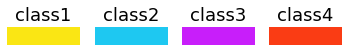

In [44]:
# определим цветовую палитру
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250, 60, 20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title(f"class{i+1}")

plt.show()

In [29]:
# определим цвета для маски
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):  # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] / 255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [30]:
# создадим маску
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)  # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [31]:
# функция для отображения маски
def show_mask_image(row_id, contour=True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST,
                                           cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:, :, ch] == 255] = palet[ch]

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [34]:
# классифицируем дефекты
idx_class_1 = list(
    filter(lambda r: not pd.isna(train_df.iloc[r, 0]), range(len(train_df))))
idx_class_2 = list(
    filter(lambda r: not pd.isna(train_df.iloc[r, 1]), range(len(train_df))))
idx_class_3 = list(
    filter(lambda r: not pd.isna(train_df.iloc[r, 2]), range(len(train_df))))
idx_class_4 = list(
    filter(lambda r: not pd.isna(train_df.iloc[r, 3]), range(len(train_df))))
# число дефектов для каждого класса
idx_no_defect = list(
    filter(lambda r: train_df.iloc[r, 4] == 0, range(len(train_df))))
idx_1_defect = list(
    filter(lambda r: train_df.iloc[r, 4] == 1, range(len(train_df))))
idx_class_multi = list(
    filter(lambda r: train_df.iloc[r, 4] >= 2, range(len(train_df))))

In [35]:
# no defect sumple
for idx in idx_no_defect[:3]:
    show_mask_image(idx)

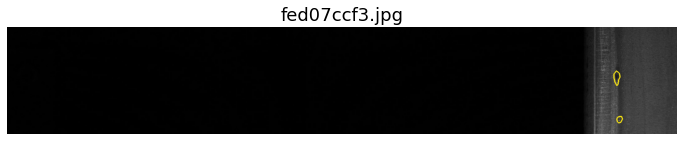

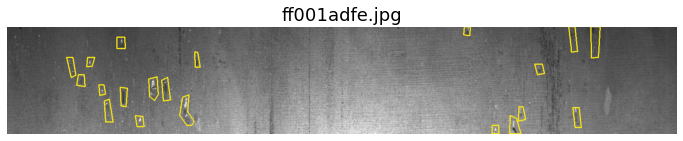

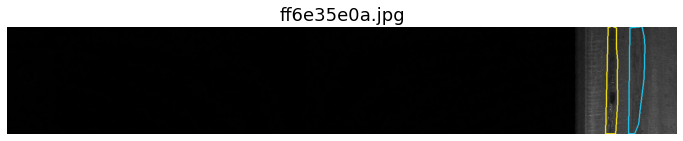

In [39]:
# class_1 - желтый
for idx in idx_class_1[-3:]:
    show_mask_image(idx, contour=True)

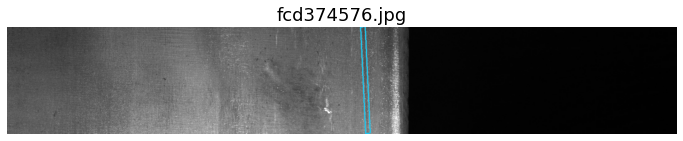

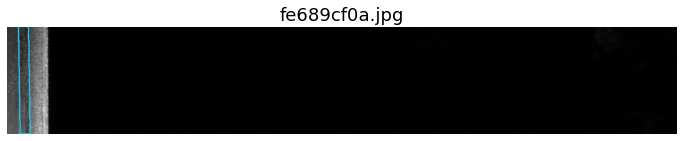

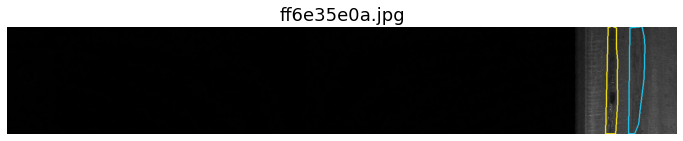

In [40]:
# class_2 - светло голубой
for idx in idx_class_2[-3:]:
    show_mask_image(idx, contour=True)

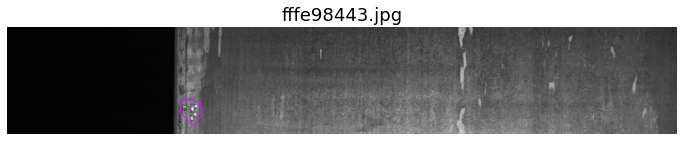

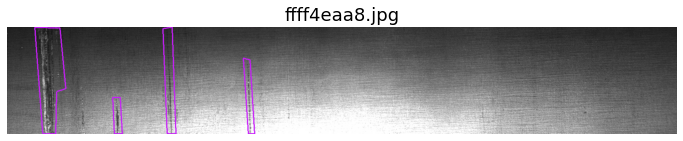

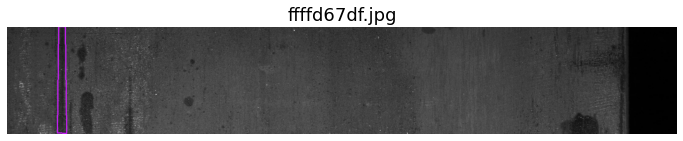

In [41]:
# class_3 - фиолетовый
for idx in idx_class_3[-3:]:
    show_mask_image(idx, contour=True)

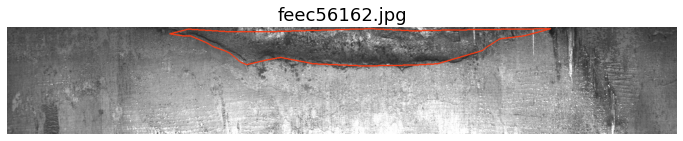

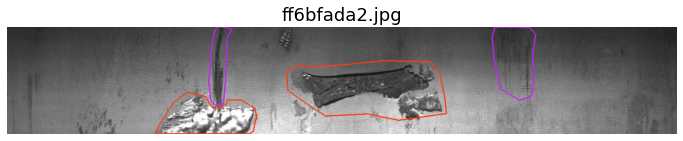

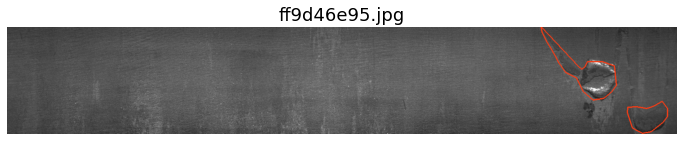

In [42]:
# class_4 - красный
for idx in idx_class_4[-3:]:
    show_mask_image(idx, contour=True)

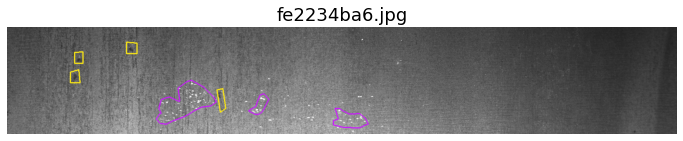

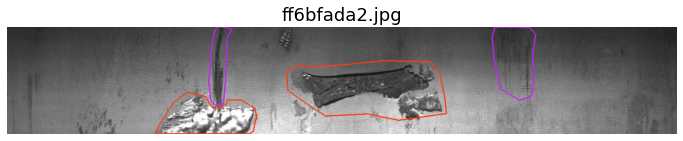

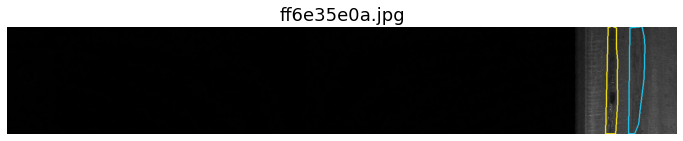

In [43]:
# пример все четырех дефектов
for idx in idx_class_multi[-3:]:
    show_mask_image(idx, contour=True)

Все четыре типа дефекта.

# Ресурсы

- https://www.kaggle.com/dumladunk/severstal-steel-defect-detection-with-xception/edit
- https://vk.com/sotamls